<a href="https://colab.research.google.com/github/sam-pitcher/dashboards_with_antipatterns_colab/blob/main/dashboards_with_antipatterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install looker_sdk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.1/348.1 kB 8.0 MB/s eta 0:00:00


In [ ]:
pip install urllib3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import looker_sdk
# import models
import urllib3
import csv
import os
import pprint as pp
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

with open('looker_api_creds.json', 'r') as f:
    looker_api_creds = json.load(f)

os.environ['LOOKERSDK_BASE_URL'] = looker_api_creds["LOOKERSDK_BASE_URL"]
os.environ['LOOKERSDK_CLIENT_ID'] = looker_api_creds["LOOKERSDK_CLIENT_ID"]
os.environ['LOOKERSDK_CLIENT_SECRET'] = looker_api_creds["LOOKERSDK_CLIENT_SECRET"]
os.environ['LOOKERSDK_VERIFY_SSL']= 'False'
os.environ['LOOKERSDK_API_VERSION']= '4.0'
os.environ["LOOKERSDK_TIMEOUT"] = "120"

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'service_account_key.json'

import pandas as pd
import json

sdk = looker_sdk.init40()

In [ ]:
import time
ts = int(time.time())

def get_dashboards():
  return(sdk.all_dashboards())

def get_dashboard_info(dashboard_id):
  dashboard = sdk.dashboard(dashboard_id)
  dashboard_id = dashboard.id
  dashboard_title = dashboard.title
  dashboard_view_count = dashboard.view_count
  return dashboard_id, dashboard_title, dashboard_view_count

def get_dashboard_elements_info(dashboard_id):
  elements = []
  dashboard_elements = sdk.dashboard_dashboard_elements(dashboard_id)
  for dashboard_element in dashboard_elements:
    try:
      hidden_fields = dashboard_element.query.vis_config['hidden_fields']
    except:
      hidden_fields = []

    elements.append({
        'element_title': dashboard_element.title,
        'hidden_fields': hidden_fields,
        'no_hidden_fields': len(hidden_fields)
      })
  return elements

def process():
  dashboards = []
  dashboard_array = get_dashboards()
  for dashboard in dashboard_array:
    dashboard_id, dashboard_title, dashboard_view_count = get_dashboard_info(dashboard.id)
    dashboard_elements = get_dashboard_elements_info(dashboard_id)

    dashboards.append({
      'dashboard_id': dashboard_id,
      'dashboard_title': dashboard_title,
      'view_count': dashboard_view_count,
      'no_tiles': 1,
      'no_queries': 1,
      'elements': dashboard_elements,
      'ts': ts
    })

  return dashboards

In [ ]:
a = process()

In [ ]:
df = pd.DataFrame(a)
df = df.astype(str)

print(df)

DATASET_NAME='dashboard_performance'
TABLE_NAME='dashboards_with_antipatterns'

df.to_gbq(f"{DATASET_NAME}.{TABLE_NAME}")


This SQL allows you to see the dashboards with lots of hidden tiles
```
with a as (select * except(elements), JSON_EXTRACT_ARRAY(elements, '$') as elements_array from `dashboard_performance.dashboards_with_antipatterns`)

SELECT
dashboard_id,
dashboard_title,
JSON_EXTRACT(elements, '$.element_title') as element_title,
CAST(JSON_EXTRACT(elements, '$.no_hidden_fields') AS INT64) as no_hidden_fields,
JSON_EXTRACT(elements, '$.hidden_fields') as hidden_fields,
FROM a
,UNNEST(elements_array) as elements

order by no_hidden_fields desc
```



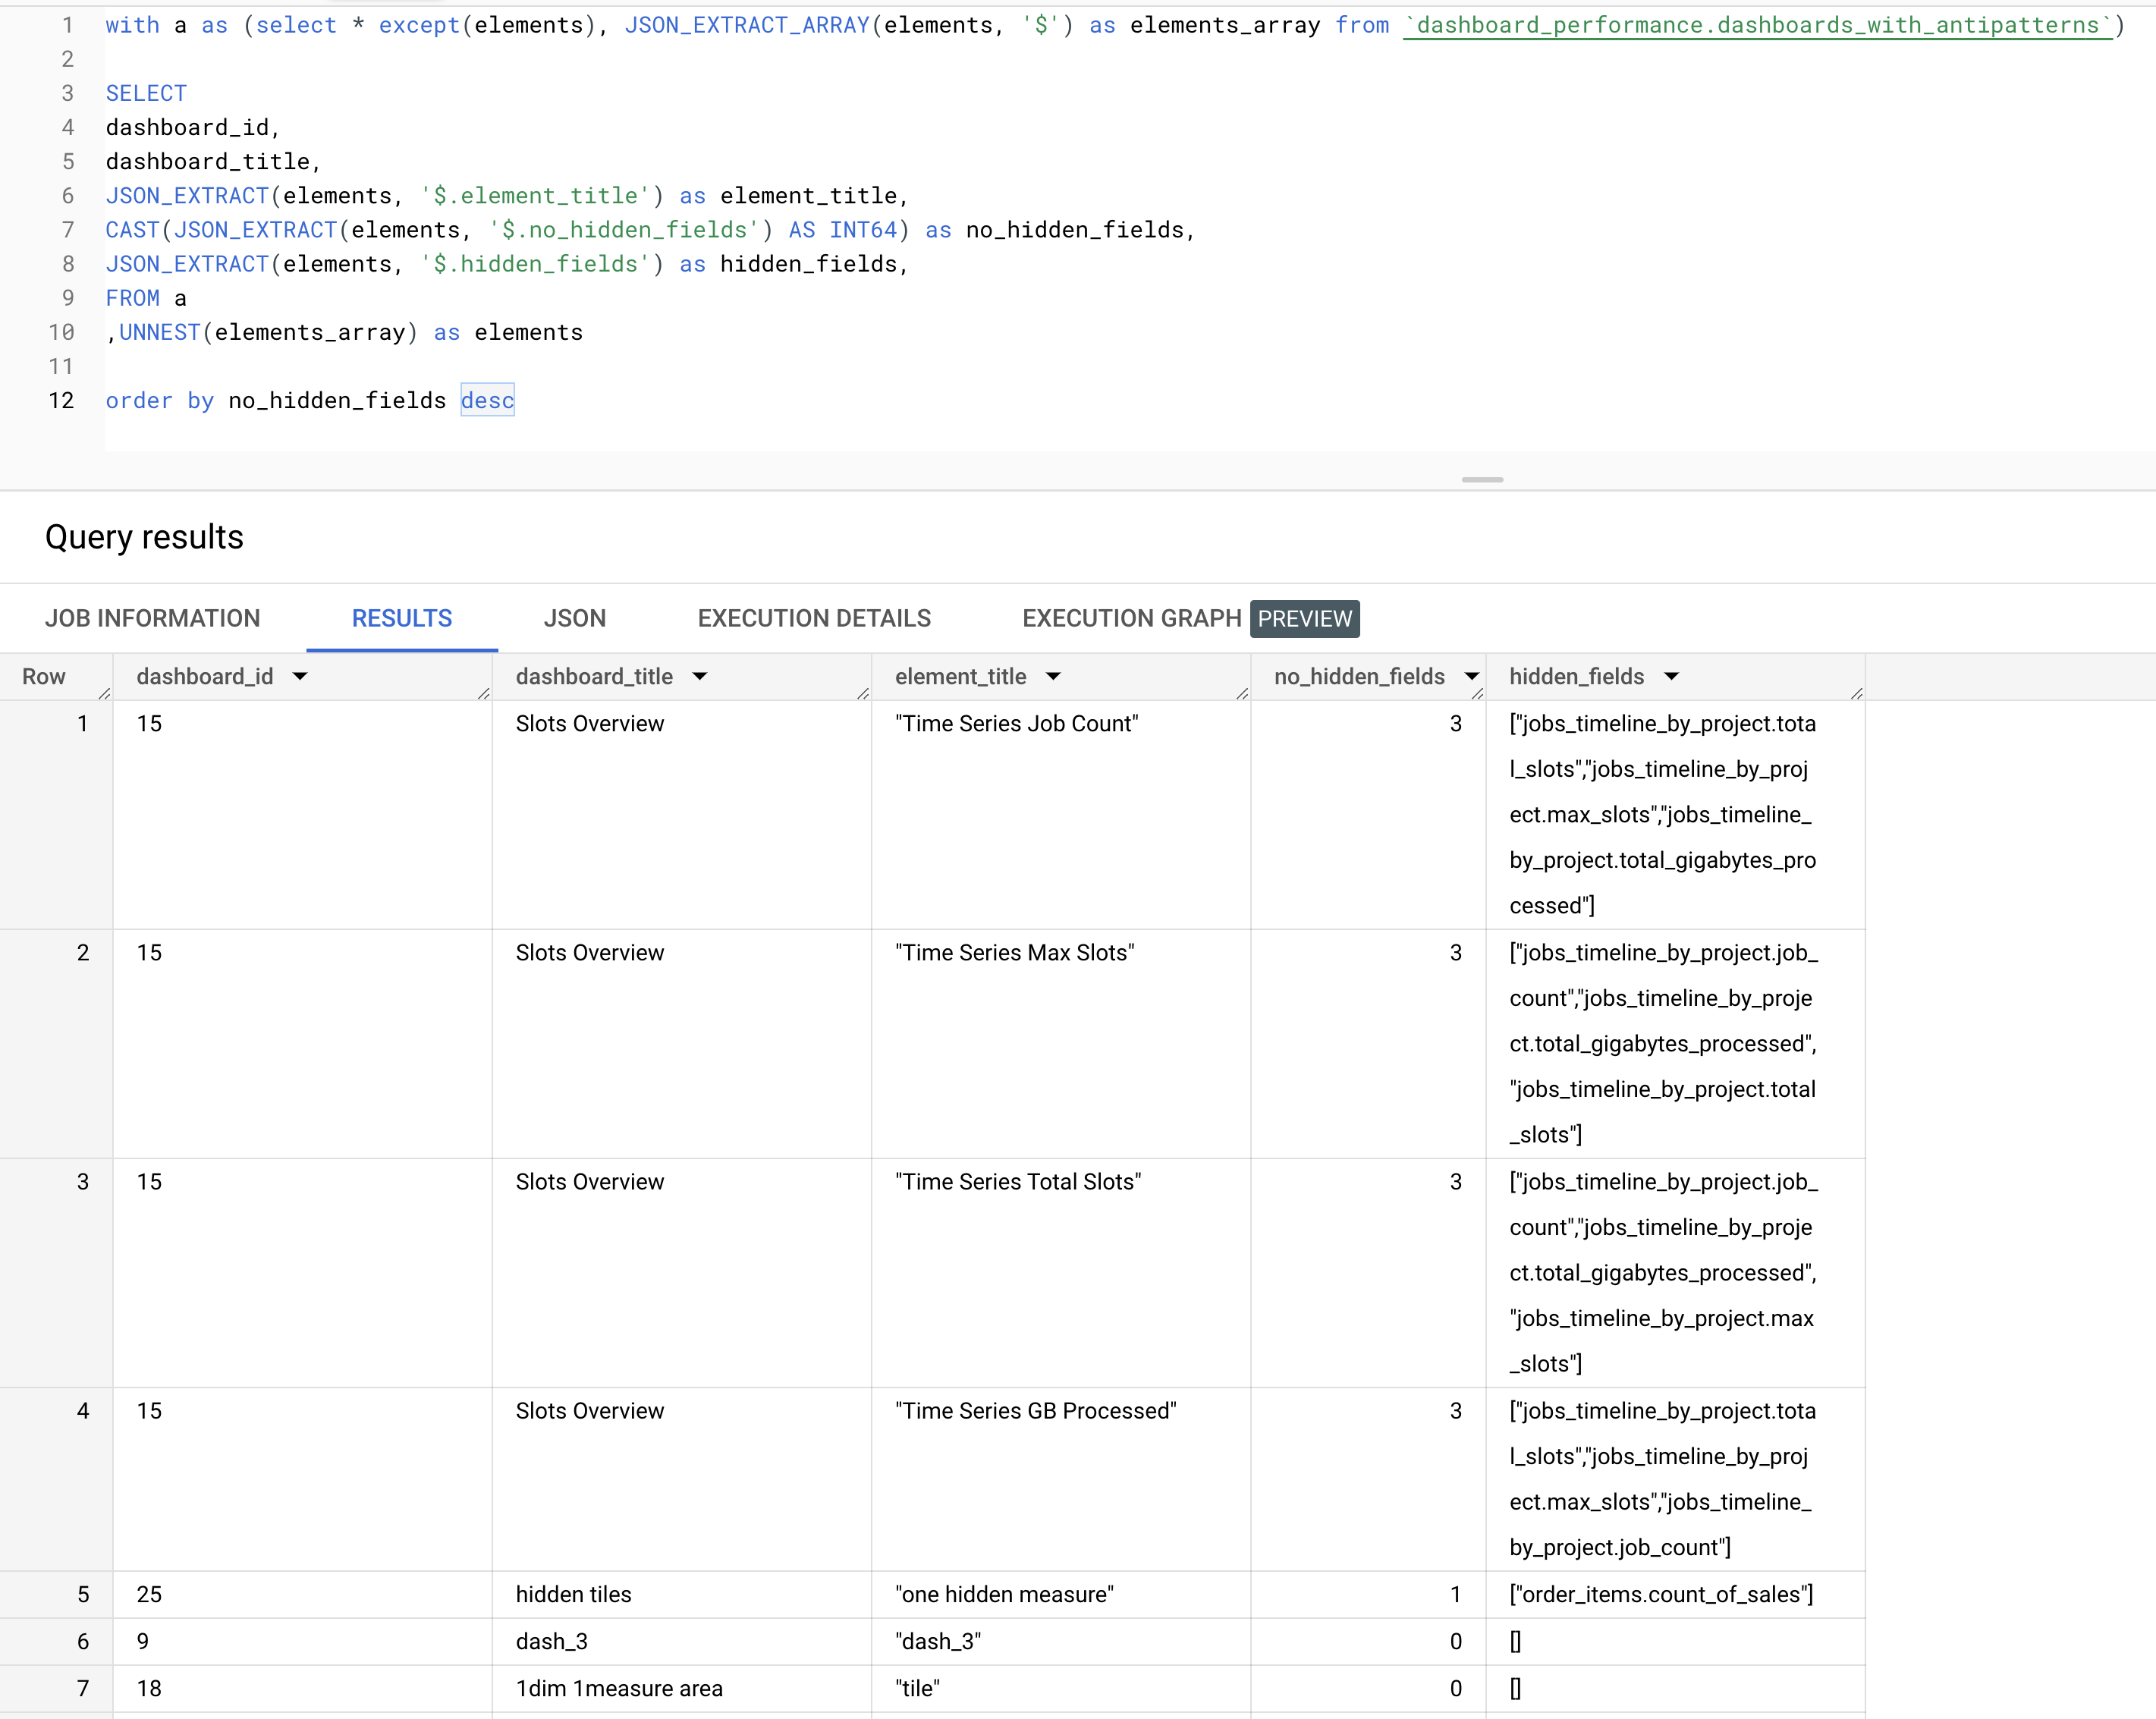

In [ ]:
# example json for bigquery table
table_json = {
    'dashboard_id': 25,
    'dashboard_title': "hidden tiles",
    'view_count': 10,
    'no_tiles': 1,
    'no_queries': 1,
    'elements': [
        {
            'id': 1,
            'title': 'test',
            'fields': [''],
            'no_fields': 3,
            'hidden_fields': [''],
            'no_hidden_fields': 1
        },
                {
            'id': 1,
            'title': 'test',
            'fields': [''],
            'no_fields': 3,
            'hidden_fields': [''],
            'no_hidden_fields': 1
        }
    ]
}